In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

2024-01-23 09:38:00.594936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 09:38:00.595026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 09:38:00.599183: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 09:38:00.617281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 09:38:03.253289: W tensorflow/compiler/tf2

In [13]:
df = pd.read_csv('Gold Price (2013-2023).csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


In [15]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [16]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,"1,689.90","1,675.80","1,695.00","1,672.10"
1,2013-01-03,"1,675.60","1,688.00","1,689.30","1,664.30"
2,2013-01-04,"1,649.90","1,664.40","1,664.40","1,630.00"
3,2013-01-07,"1,647.20","1,657.30","1,663.80","1,645.30"
4,2013-01-08,"1,663.20","1,651.50","1,662.60","1,648.80"


In [18]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [19]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-02,1689.9,1675.8,1695.0,1672.1
1,2013-01-03,1675.6,1688.0,1689.3,1664.3
2,2013-01-04,1649.9,1664.4,1664.4,1630.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3
4,2013-01-08,1663.2,1651.5,1662.6,1648.8


In [20]:
validation = df[-100:]
df = df[:-100]

In [21]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [24]:
fig = px.line(y=validation.Price, x=validation.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [25]:
df[df.Date.dt.year==2022].shape

(160, 5)

In [26]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

160

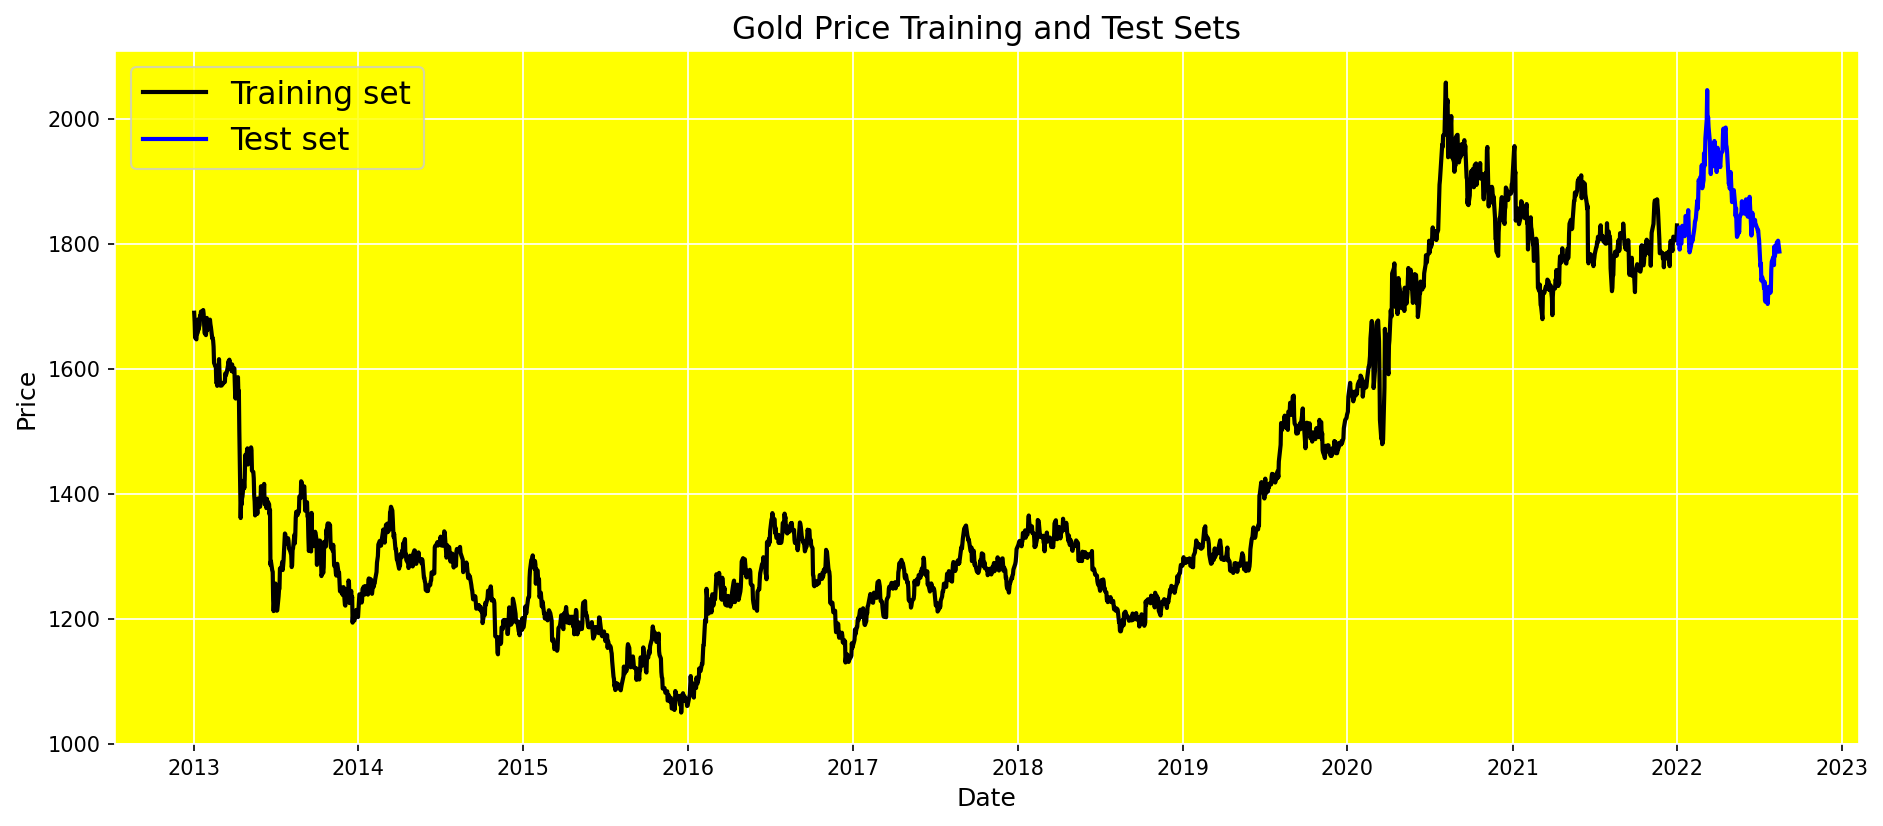

In [27]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [28]:
df.Price.values

array([1689.9, 1675.6, 1649.9, ..., 1796.8, 1805.2, 1787.9])

In [29]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [30]:
window_size = 60

In [31]:
train_data = df.Price[:-test_size]
train_data

0       1689.9
1       1675.6
2       1649.9
3       1647.2
4       1663.2
         ...  
2318    1808.8
2319    1810.9
2320    1805.8
2321    1815.3
2322    1829.7
Name: Price, Length: 2323, dtype: float64

In [32]:
train_data = scaler.transform(train_data.values.reshape(-1,1))
len(train_data)

2323

In [33]:
for i in range(window_size, len(train_data)):
    print(f"i-60: {i-60}, i: {i}")

i-60: 0, i: 60
i-60: 1, i: 61
i-60: 2, i: 62
i-60: 3, i: 63
i-60: 4, i: 64
i-60: 5, i: 65
i-60: 6, i: 66
i-60: 7, i: 67
i-60: 8, i: 68
i-60: 9, i: 69
i-60: 10, i: 70
i-60: 11, i: 71
i-60: 12, i: 72
i-60: 13, i: 73
i-60: 14, i: 74
i-60: 15, i: 75
i-60: 16, i: 76
i-60: 17, i: 77
i-60: 18, i: 78
i-60: 19, i: 79
i-60: 20, i: 80
i-60: 21, i: 81
i-60: 22, i: 82
i-60: 23, i: 83
i-60: 24, i: 84
i-60: 25, i: 85
i-60: 26, i: 86
i-60: 27, i: 87
i-60: 28, i: 88
i-60: 29, i: 89
i-60: 30, i: 90
i-60: 31, i: 91
i-60: 32, i: 92
i-60: 33, i: 93
i-60: 34, i: 94
i-60: 35, i: 95
i-60: 36, i: 96
i-60: 37, i: 97
i-60: 38, i: 98
i-60: 39, i: 99
i-60: 40, i: 100
i-60: 41, i: 101
i-60: 42, i: 102
i-60: 43, i: 103
i-60: 44, i: 104
i-60: 45, i: 105
i-60: 46, i: 106
i-60: 47, i: 107
i-60: 48, i: 108
i-60: 49, i: 109
i-60: 50, i: 110
i-60: 51, i: 111
i-60: 52, i: 112
i-60: 53, i: 113
i-60: 54, i: 114
i-60: 55, i: 115
i-60: 56, i: 116
i-60: 57, i: 117
i-60: 58, i: 118
i-60: 59, i: 119
i-60: 60, i: 120
i-60: 61, i: 

In [34]:
train_data[0:60, 0]

array([0.63471451, 0.62053925, 0.59506344, 0.59238699, 0.60824742,
       0.60160587, 0.6239096 , 0.60666138, 0.61538462, 0.62975813,
       0.62906423, 0.63659794, 0.63283109, 0.63798573, 0.638977  ,
       0.6325337 , 0.61588025, 0.60269627, 0.59912768, 0.60676051,
       0.62648692, 0.60705789, 0.61558287, 0.62133228, 0.61845757,
       0.62371134, 0.61627676, 0.61191515, 0.59427042, 0.59476606,
       0.59030531, 0.58078906, 0.55501586, 0.54976209, 0.54976209,
       0.52379064, 0.52438541, 0.518636  , 0.53231562, 0.56096352,
       0.54302141, 0.52468279, 0.51893339, 0.51913164, 0.52160983,
       0.52160983, 0.52190722, 0.52369151, 0.52478192, 0.53836241,
       0.5350912 , 0.53737113, 0.53925456, 0.55105075, 0.55769231,
       0.55392546, 0.5601705 , 0.55253767, 0.55095163, 0.54203013])

In [35]:
train_data[60, 0]

0.5527359238699445

In [36]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [37]:
X_train

[array([0.63471451, 0.62053925, 0.59506344, 0.59238699, 0.60824742,
        0.60160587, 0.6239096 , 0.60666138, 0.61538462, 0.62975813,
        0.62906423, 0.63659794, 0.63283109, 0.63798573, 0.638977  ,
        0.6325337 , 0.61588025, 0.60269627, 0.59912768, 0.60676051,
        0.62648692, 0.60705789, 0.61558287, 0.62133228, 0.61845757,
        0.62371134, 0.61627676, 0.61191515, 0.59427042, 0.59476606,
        0.59030531, 0.58078906, 0.55501586, 0.54976209, 0.54976209,
        0.52379064, 0.52438541, 0.518636  , 0.53231562, 0.56096352,
        0.54302141, 0.52468279, 0.51893339, 0.51913164, 0.52160983,
        0.52160983, 0.52190722, 0.52369151, 0.52478192, 0.53836241,
        0.5350912 , 0.53737113, 0.53925456, 0.55105075, 0.55769231,
        0.55392546, 0.5601705 , 0.55253767, 0.55095163, 0.54203013]),
 array([0.62053925, 0.59506344, 0.59238699, 0.60824742, 0.60160587,
        0.6239096 , 0.60666138, 0.61538462, 0.62975813, 0.62906423,
        0.63659794, 0.63283109, 0.63798573, 0.

In [38]:
test_data = df.Price[-test_size-60:]
test_data

2263    1757.4
2264    1755.7
2265    1759.3
2266    1794.7
2267    1797.9
         ...  
2478    1801.5
2479    1803.3
2480    1796.8
2481    1805.2
2482    1787.9
Name: Price, Length: 220, dtype: float64

In [39]:
test_data[i-60:i, 0] = scaler.transform(test_data.values.reshape(-1,1))

In [40]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [41]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [42]:
X_train

array([[0.63471451, 0.62053925, 0.59506344, ..., 0.55253767, 0.55095163,
        0.54203013],
       [0.62053925, 0.59506344, 0.59238699, ..., 0.55095163, 0.54203013,
        0.55273592],
       [0.59506344, 0.59238699, 0.60824742, ..., 0.54203013, 0.55273592,
        0.54133624],
       ...,
       [0.70509516, 0.70598731, 0.70340999, ..., 0.75545202, 0.75257732,
        0.754659  ],
       [0.70598731, 0.70340999, 0.70162569, ..., 0.75257732, 0.754659  ,
        0.74960349],
       [0.70340999, 0.70162569, 0.69994052, ..., 0.754659  , 0.74960349,
        0.75902062]])

In [43]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2263, 60)
y_train Shape:  (2263,)
X_test Shape:   (160, 60)
y_test Shape:   (160,)


In [44]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [45]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

In [46]:
result = model.evaluate(X_test, y_test)
result

5/5 [==============================] - 0s 66ms/step - loss: 6.6226e-04


0.0006622566725127399

In [48]:
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 69ms/step


In [49]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [50]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0006622566725127399
Test MAPE: 0.02544316723995247
Test Accuracy: 0.9745568327600476


In [51]:
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred = scaler.inverse_transform(y_pred)

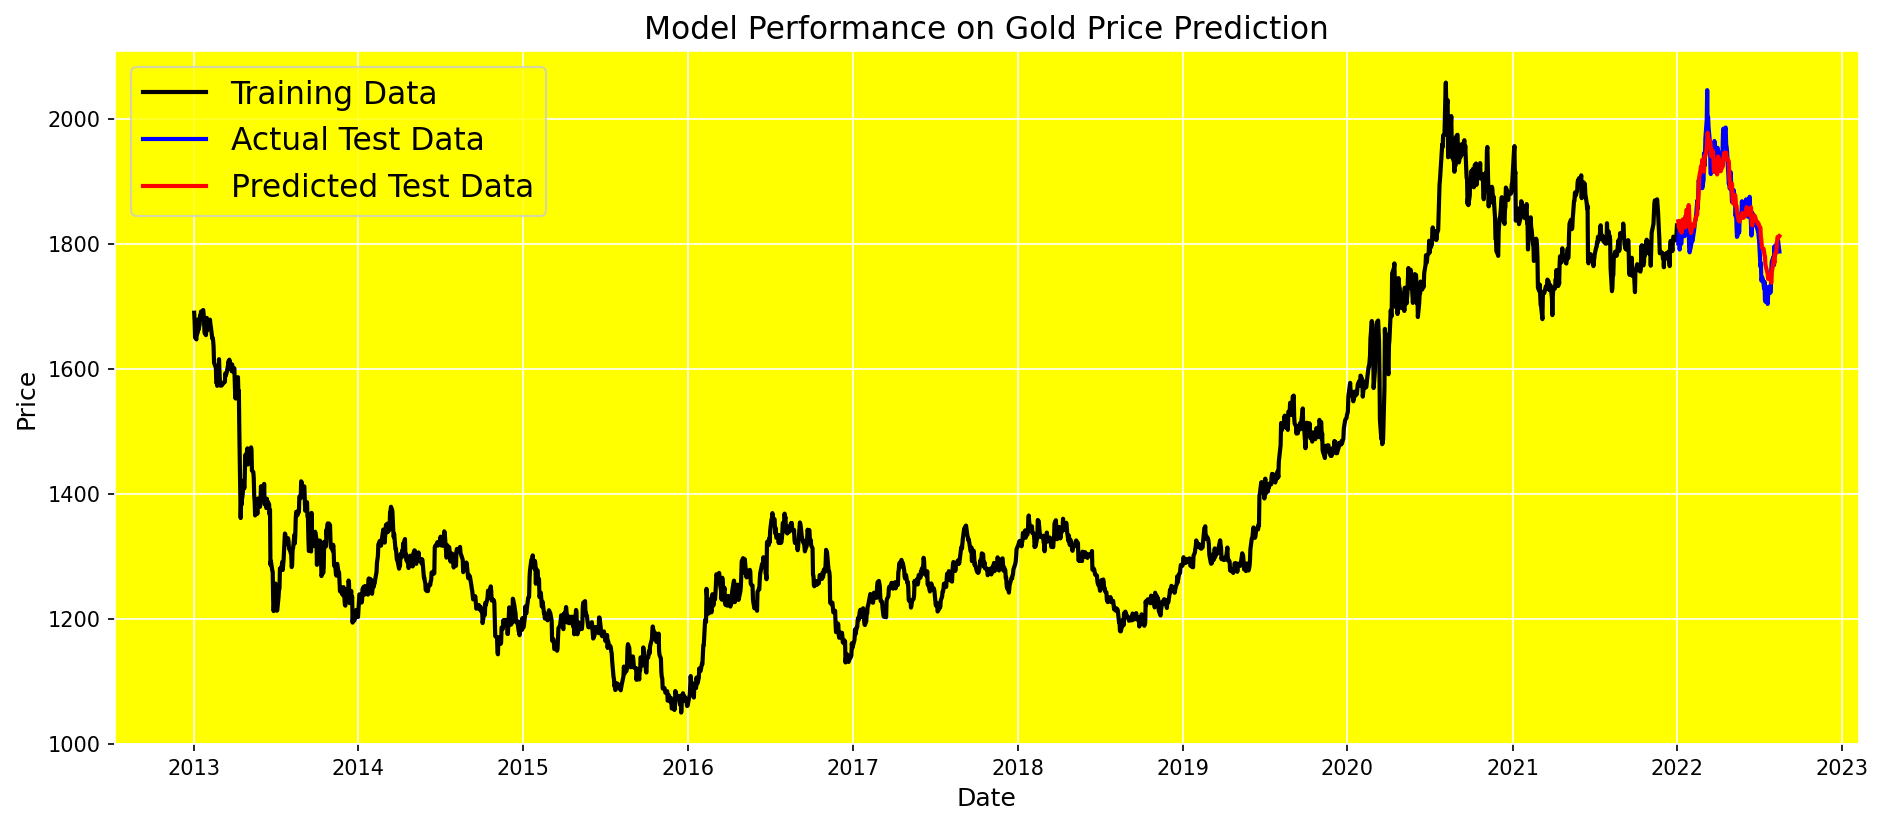

In [52]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [161]:
validation

,Date,Price,Open,High,Low
2483,2022-08-16,1779.4,1785.2,1787.60,1775.20
2484,2022-08-17,1766.5,1780.5,1786.30,1763.70
2485,2022-08-18,1761.1,1766.3,1775.90,1758.90
2486,2022-08-19,1753.0,1762.7,1762.70,1749.50
2487,2022-08-22,1738.6,1750.5,1752.30,1730.40
...,...,...,...,...,...
2578,2022-12-26,1809.7,1805.8,1811.95,1805.55
2579,2022-12-27,1823.1,1808.2,1841.90,1808.00
2580,2022-12-28,1815.8,1822.4,1822.80,1804.20
2581,2022-12-29,1826.0,1812.3,1827.30,1811.20


In [200]:
preds = []

In [201]:
for i in range(0, 40):
    first_log = validation[i:i+60].Price
    first_log = scaler.transform(first_log.values.reshape(-1, 1))
    first_log = first_log[i:i+60, 0]
    new_input = []
    new_input.append(first_log)
    new_input = np.array(new_input)
    pred = model.predict(new_input)
    pred = scaler.inverse_transform(pred)
    preds.append(pred)

1/1 [==============================] - 0s 87ms/step


In [205]:
preds[:10], len(preds), len(validation.Price.iloc[60:])

([array([[1667.5367]], dtype=float32),
  array([[1678.4102]], dtype=float32),
  array([[1701.8441]], dtype=float32),
  array([[1703.2115]], dtype=float32),
  array([[1725.8864]], dtype=float32),
  array([[1744.4327]], dtype=float32),
  array([[1755.3595]], dtype=float32),
  array([[1760.1404]], dtype=float32),
  array([[1765.3883]], dtype=float32),
  array([[1765.3816]], dtype=float32)],
 40,
 40)

In [216]:
convert_preds = []
for i in preds:
    convert_preds.append(i[0][0])

Text(0.5, 1.0, 'prediction vs actual')

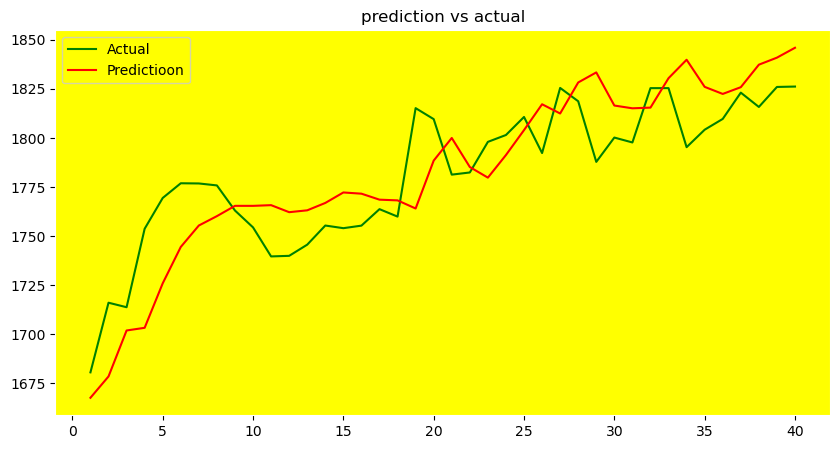

In [225]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 41), validation.Price.iloc[60:], c='green', label='Actual')
plt.plot(np.arange(1, 41), convert_preds, c='Red', label='Predictioon')
plt.legend()
plt.title("prediction vs actual")

In [226]:
MAPE = mean_absolute_percentage_error(validation.Price.iloc[60:], convert_preds)
Accuracy = 1 - MAPE

In [227]:
Accuracy

0.9891303951138474

In [152]:
new_input = np.array(new_input)
new_input.shape

(1, 59)

In [153]:
scaler.inverse_transform(new_input)

array([[1761.1 , 1753.  , 1738.6 , 1751.5 , 1752.  , 1761.8 , 1740.6 ,
        1740.5 , 1731.6 , 1721.4 , 1704.4 , 1717.7 , 1718.65, 1724.8 ,
        1707.9 , 1722.8 , 1715.3 , 1723.6 , 1735.6 , 1712.  , 1703.2 ,
        1671.4 , 1677.9 , 1672.6 , 1665.7 , 1670.5 , 1676.1 , 1650.  ,
        1628.2 , 1631.1 , 1665.1 , 1668.6 , 1672.  , 1702.  , 1730.5 ,
        1720.8 , 1720.8 , 1709.3 , 1675.2 , 1686.  , 1677.5 , 1677.  ,
        1643.7 , 1658.9 , 1650.7 , 1629.  , 1631.8 , 1651.5 , 1649.2 ,
        1653.3 , 1664.4 , 1660.3 , 1644.8 , 1640.7 , 1649.7 , 1650.  ,
        1630.9 , 1676.6 , 1680.5 ]])

In [154]:
javab

1716.0

In [155]:
pred = model.predict(new_input)
pred

1/1 [==============================] - 0s 49ms/step


array([[0.62332493]], dtype=float32)

In [156]:
pred = scaler.inverse_transform(pred)
pred

array([[1678.4102]], dtype=float32)

In [157]:
javab

1716.0